Processing file:  1
Points:  92
Mean Velocity:  32.82
Optimized Length Scale:  21
Processing file:  2
Points:  89
Mean Velocity:  43.57
Optimized Length Scale:  27
Processing file:  3
Points:  86
Mean Velocity:  51.83
Optimized Length Scale:  33
Processing file:  4
Points:  78
Mean Velocity:  61.38
Optimized Length Scale:  40
Processing file:  5
Points:  71
Mean Velocity:  70.38
Optimized Length Scale:  48


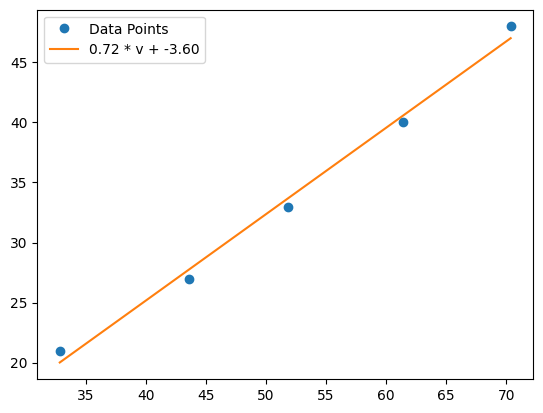

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
%matplotlib inline


def optimize_kernels(x, y1, y2, length_scales, alpha=0.01, rounds=10):
    likelihoods = []
    for l in length_scales:
        avg_lh = 0
        for i in range(rounds):
            np.random.seed(i)
            size = int(0.5 * x.shape[0])
            idx = np.random.choice(x.shape[0], size, replace=False)
            x_train = x[idx]
            x_test = x
            kernel = RBF(length_scale=l, length_scale_bounds='fixed')
            gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, alpha=alpha, normalize_y=True)

            # fit the model twice and calculate joint log likelihood for both y1 and y2
            y_train = y1[idx]
            y_test = y1
            gp.fit(x_train.reshape(-1, 1), y_train)
            y_pred, y_std = gp.predict(x_test.reshape(-1, 1), return_std=True)
            log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * y_std**2) + ((y_test - y_pred)**2) / (y_std**2))
            avg_lh += log_likelihood # likelhood for y1
            y_train = y2[idx]
            y_test = y2
            gp.fit(x_train.reshape(-1, 1), y_train)
            y_pred, y_std = gp.predict(x_test.reshape(-1, 1), return_std=True)
            log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * y_std**2) + ((y_test - y_pred)**2) / (y_std**2))
            avg_lh += log_likelihood # add likelihood for y2 -> joint likelihood
                                                  

        avg_lh /= rounds
        likelihoods.append(avg_lh)
    best_length_scale = length_scales[np.argmax(likelihoods)]
    return best_length_scale


length_scales = []
v_means = []
# 5 files with different velocities
for i in range(1, 6):
    print("Processing file: ", i)
    data = np.genfromtxt(f'data/v{i}.csv', delimiter=',', skip_header=1)

    slc = 15 # reduce sample rate to ~5Hz
    t = data[::slc, 0]
    x = data[::slc, 1]
    y = data[::slc, 2]
    v = data[::slc, 3]


    n = x.shape[0]
    print("Points: ", n)

    ds = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    ds = np.concatenate((ds, [ds[-1]]))
    s = np.cumsum(ds) # arc length

    v_mean = v.mean()
    v_means.append(v_mean)
    print("Mean Velocity: ", round(v_mean, 2))

    noise_std = 0.01
    l_scales = np.arange(1, 100, 1)
    optimized_length_scale = optimize_kernels(s, x, y, l_scales, alpha=noise_std**2, rounds=30)
    print("Optimized Length Scale: ", optimized_length_scale)
    
    length_scales.append(optimized_length_scale)

plt.plot(v_means, length_scales, 'o', label='Data Points')
[a, b] = np.polyfit(v_means, length_scales, 1)
plt.plot(v_means, a * np.array(v_means) + b, label=f'{a:.2f} * v + {b:.2f}')
plt.legend()
plt.show()


